In [1]:
from numbers_parser import Document
import pandas as pd
import glob,os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.optimize import minimize,root_scalar

array([19.63873676, -8.71678951,  4.44265123])

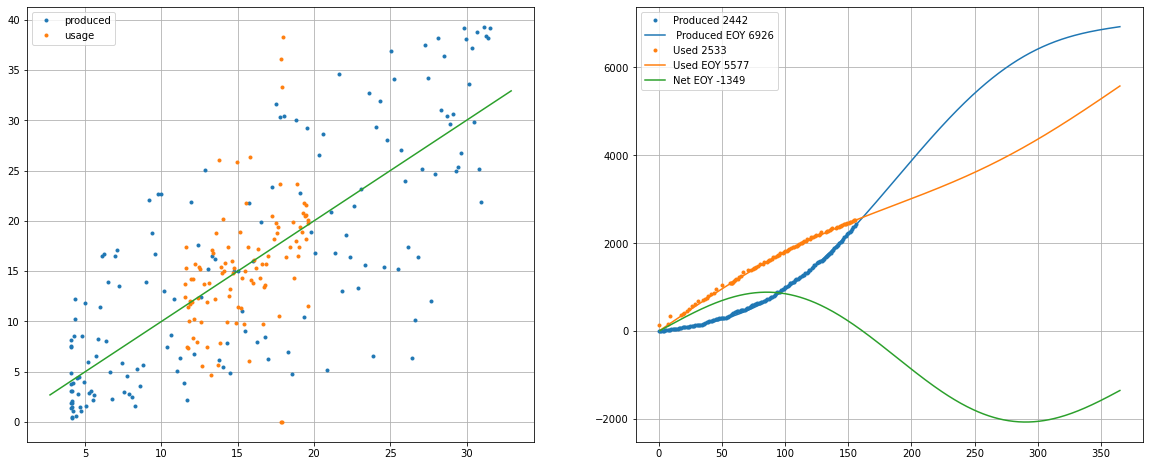

In [43]:
class Energy:
    def __init__(self,production_params=None,usage_params=None) -> None:
        if production_params is None:
            self.production_params = np.array([5,30, 10])
        else:
            self.production_params=production_params

        if usage_params is None:
            self.usage_params = np.array([20, -10, 15])
        else:
            self.usage_params=usage_params

    def load_meter(self,file):
        doc = Document(file)
        sheets = doc.sheets()
        s = sheets['Electricity']
        data = s.tables['Inputs'].rows(values_only=True)
        meter = pd.DataFrame(data[1:], columns=data[0])[['Date ', 'Meter']]
        meter = meter.rename(columns={x:x.lower().replace(' ','') for x in meter.columns})
        meter['date']=[x.replace(tzinfo=None) for x in meter['date']]
        meter['from']=meter['date'].shift(1)
        meter['to']=meter['date']
        meter['net_used'] = meter['meter'].diff(1)
        #meter['net_cum_used'] = meter['net_used'].cumsum()

        
        self.meter_df = meter
        return self
    
    def compute_total_used(self):
        d0 = datetime(2023,1,1)
        t_interp = (self.produced_df['to']-d0)/timedelta(days=1)
        y_interp = self.produced_df['cum_produced'].values
        t_interp=t_interp.values
        
        f_interp = interp1d(t_interp,y_interp,fill_value=np.nan,bounds_error=False)
        t_eval0 = (self.meter_df['from']-d0)/timedelta(days=1)
        t_eval1 = (self.meter_df['to']-d0)/timedelta(days=1)

        self.meter_df['produced'] = f_interp(t_eval1)-f_interp(t_eval0)
        self.meter_df['used']=self.meter_df['produced']+self.meter_df['net_used']
        self.meter_df['used']=self.meter_df['used']+np.maximum(-self.meter_df['used'],0)
        self.meter_df['produced']=self.meter_df['produced']+np.maximum(-self.meter_df['used'],0)

        return self


    
    def load_produced(self,file):
        produced = pd.read_csv(fn).rename(columns={'Date/Time':'Date','Energy Produced (Wh)':'Produced'})
        produced=produced.head(produced.shape[0]-1)
        produced['Date']=pd.to_datetime(produced['Date'])
        produced=produced.rename(columns={'Date':'from','Produced':'produced'})
        produced['to'] = produced['from']+pd.Timedelta(days=1)-pd.Timedelta(seconds=1)
        produced=produced[['from','to','produced']]
        produced['produced']=[float(x.replace(',',''))/1000 for x in produced['produced'].values]
        produced['cum_produced'] = produced['produced'].values.cumsum()
        produced=produced.loc[produced['cum_produced']>0]
        
        self.produced_df = produced
        return self
    
    def production(self,d,params=None):
        if params is None:
            params = self.production_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_production(self,d,params=None):
        xx = np.arange(365)+1
        prod = self.production(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],prod.cumsum()])
        return interp1d(xx,yy)(d)

    def fit_production(self,last_d=None):
        fitting_set = self.produced_df.copy()
        if last_d is not None:
            ind = fitting_set['to']<=last_d
            fitting_set=fitting_set.loc[ind]
        day_of_year=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        data = fitting_set['produced'].values

        def x_to_params(x):
            params = np.array([0,x[0],x[1]])
            mu = self.production(day_of_year,params=params).mean()
            params[0]=data.mean()-mu
            params[1]=x[0]
            params[2]=x[1]
            return params
            
        def f_tar(x):
            params = x_to_params(x)
            model = self.production(day_of_year,params=params)
            return np.sum((model-data)**2)
            
        #f_tar = lambda params: np.sum((self.production(day_of_year,params=params)-fitting_set['produced'].values)**2)
        sol = minimize(f_tar,self.production_params[1:],bounds=((0,1000),(0,365)))
        self.production_params=x_to_params(sol.x)
        return self
    
    def plot_production(self,ax=None):
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            fig,ax = plt.subplots(1,2,figsize=(10,5))

        ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = np.arange(365)+1
        ax[0].plot(x,self.production(x))
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.')
        ax[1].plot(x,self.cum_production(x))

        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)
        title=f'Produced {produced:0.0f}, EOY = {produced_eoy:0.0f}'
        ax[1].set_title(title)
        
        for ax_ in np.ravel([ax]):
            ax_.grid(True)

    def usage(self,d,params=None):
        if params is None:
            params = self.usage_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        #c=0
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_usage(self,d,params=None):
        xx = np.arange(365)+1
        usage = self.usage(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],usage.cumsum()])
        
        return interp1d(xx,yy)(d)



    def fit_use(self,last_d = None):
        fitting_set = self.meter_df.copy()
        fitting_set=fitting_set.dropna()
        if last_d is not None:
            ind = fitting_set['to']<=last_d
            fitting_set=fitting_set.loc[ind]

            
        
        day_of_year0=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year0=day_of_year0.values

        day_of_year1=(fitting_set['to']-fitting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        norm = 1//(day_of_year1-day_of_year0)
        norm=1
        data = fitting_set['used'].values*norm
        def x_to_params(x):
            return x
            params = [0,x[0],x[1]]
            mu = (self.cum_usage(day_of_year1,params=params)*norm).mean()-(self.cum_usage(day_of_year0,params=params)*norm).mean()
            return [data.mean()-mu,x[0],x[1]]
        def f_tar(x):
            params = x_to_params(x)
            model = (self.cum_usage(day_of_year1,params=params)-self.cum_usage(day_of_year0,params=params))*norm
            return np.sum((model-data)**2)

        
        
        #f_tar = lambda params: np.sum(((self.cum_usage(day_of_year1,params=params)-self.cum_usage(day_of_year0,params=params) - fitting_set['used'])/(day_of_year1-day_of_year0))**2)
        sol = minimize(f_tar,self.usage_params,bounds=((0,10000),(-100,100),(0,365)))
        self.usage_params=x_to_params(sol.x)
        return self
    
    def plot_usage(self,ax=None):
        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            plt.figure()
            ax=plt.gca()
        ax.plot(day_of_year,plotting_set['used'].cumsum(),'.')
        x=np.arange(365)+1
        ax.plot(x,self.cum_usage(x))
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        title=f'Used {used:0.0f}, EOY = {used_eoy:0.0f}'
        ax.set_title(title)
        ax.grid(True)
    
    def plot(self):
        fig,ax=plt.subplots(1,2,figsize=(20,8))
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)

        #ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = day_of_year
        #ax[0].plot(x,self.production(x))
        ax[0].plot(self.production(x),plotting_set['produced'],'.',label='produced')
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.',label=f'Produced {produced:0.0f}',color='C0')
        x=np.arange(365)+1
        ax[1].plot(x,self.cum_production(x),label=f' Produced EOY {produced_eoy:0.0f}',color='C0')



        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]
        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values

        day_of_year1=(plotting_set['to']-plotting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        ax[0].plot((self.cum_usage(day_of_year1)-self.cum_usage(day_of_year))/(day_of_year1-day_of_year),plotting_set['used']/(day_of_year1-day_of_year),'.',label='usage')
        xx = ax[0].get_xlim()
        ax[0].plot(xx,xx)
        
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        
        ax[1].plot(day_of_year,plotting_set['used'].cumsum(),'.',label=f'Used {used:0.0f}',color='C1')
        
        ax[1].plot(x,self.cum_usage(x),label=f'Used EOY {used_eoy:0.0f}',color='C1')
        
        
        ax[1].plot(x,self.cum_usage(x)-self.cum_production(x),label=f'Net EOY {used_eoy-produced_eoy:0.0f}',color='C2')


        for ax_ in np.ravel([ax]):
            ax_.grid(True)
            ax_.legend()

        



        

    

        

    
e=Energy()
folder = '/Users/manuel/Downloads/'

suffix = np.max([int(os.path.basename(x).replace('.csv','').split('_')[-1]) for x in glob.glob(os.path.join(folder,'3693411*.csv'))]).astype(str)
fn = os.path.join(folder,f'3693411_system_energy_20221218_to_{suffix}.csv')
e.load_produced(fn)
e.load_meter("/Users/manuel/OneDrive/Meterstanden.numbers")

e.produced_df
last_d = None
#last_d=datetime(2023,5,15)
e.fit_production(last_d=last_d)
#e.plot_production()
e.compute_total_used()
e.fit_use(last_d=last_d)
#e.plot_usage()
#e.plot_production()
e.plot()
plt.savefig('plot.pdf')
e.usage_params


In [29]:
e.meter_df

,date,meter,from,to,net_used,produced,used
0,2022-12-22 00:00:00,28620.0,NaT,2022-12-22 00:00:00,NaN,NaN,NaN
1,2023-01-01 00:00:00,28781.0,2022-12-22 00:00:00,2023-01-01 00:00:00,161.0,NaN,NaN
2,2023-01-08 00:00:00,28896.0,2023-01-01 00:00:00,2023-01-08 00:00:00,115.0,23.489059,138.489059
3,2023-01-10 00:00:00,28907.0,2023-01-08 00:00:00,2023-01-10 00:00:00,11.0,12.025927,23.025927
4,2023-01-19 00:00:00,29052.0,2023-01-10 00:00:00,2023-01-19 00:00:00,145.0,36.028119,181.028119
...,...,...,...,...,...,...,...
99,2023-06-03 09:12:24,28968.0,2023-06-02 09:54:55,2023-06-03 09:12:24,-11.0,27.915064,16.915064
100,2023-06-04 09:33:52,28944.0,2023-06-03 09:12:24,2023-06-04 09:33:52,-24.0,39.520956,15.520956
101,2023-06-05 08:04:22,28921.0,2023-06-04 09:33:52,2023-06-05 08:04:22,-23.0,35.912398,12.912398
102,2023-06-06 08:00:30,28895.0,2023-06-05 08:04:22,2023-06-06 08:00:30,-26.0,38.392932,12.392932


In [28]:
e.produced_df

,from,to,produced,cum_produced
4,2022-12-22,2022-12-22 23:59:59,1.743,1.743
5,2022-12-23,2022-12-23 23:59:59,0.390,2.133
6,2022-12-24,2022-12-24 23:59:59,4.275,6.408
7,2022-12-25,2022-12-25 23:59:59,0.574,6.982
8,2022-12-26,2022-12-26 23:59:59,3.410,10.392
...,...,...,...,...
166,2023-06-02,2023-06-02 23:59:59,21.872,2306.613
167,2023-06-03,2023-06-03 23:59:59,39.308,2345.921
168,2023-06-04,2023-06-04 23:59:59,38.372,2384.293
169,2023-06-05,2023-06-05 23:59:59,38.150,2422.443


In [20]:
d=datetime.now()-datetime(2023,1,1)
d=d/timedelta(days=1)

e.cum_usage(d)-e.cum_production(d)

186.4312463730289

In [23]:
e.produced_df.loc[e.produced_df['from'].apply(lambda x: x.year==2023),'produced'].sum()

2402.3270000000007

In [24]:
e.cum_production(d)

array(2417.56001581)

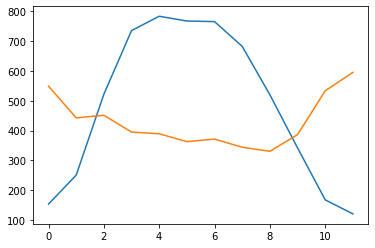

In [3]:
estimate=np.array([154,251,522,735,783,767,765,682,520,342,168,121])
used_2022=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
plt.plot(estimate)
plt.plot(used_2022)